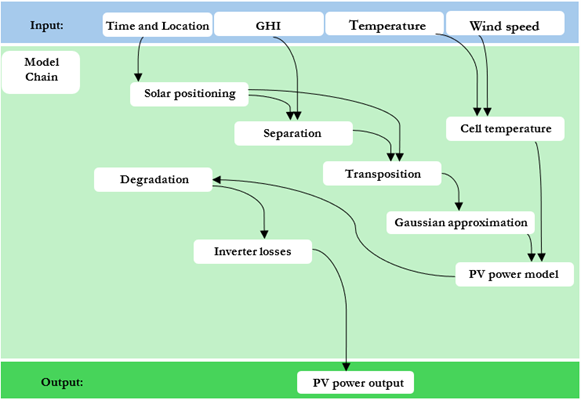

## Governing Power Model

$$
P_{\text{solar}} = \frac{P_{\text{STC}} \cdot G_c}{1000 \, \text{W/m}^2} \left[ 1 + \gamma \left( T_{\text{cell}} - 25^\circ\text{C} \right) \right]
$$

<p style="text-align: left;">\(G_{\text{c}} \) : In-plane global irradiance (W/m\(^2\)), representing the solar irradiance on the plane of the PV module.

<p style="text-align: left;">\(T_{\text{cell}} \) : Cell temperature (°C), indicating the temperature of the solar cell during operation.
<p style="text-align: left;">\(P_{\text{STC}} \) : PV power at standard test conditions (W), which is the rated power of the photovoltaic module under standardized conditions (irradiance of 1000 W/m\(^2\), cell temperature of 25°C, and air mass of 1.5).
<p style="text-align: left;">\({gamma} \)  : Temperature coefficient of the solar cell (-0.41%/°C), defining how the power output of the solar cell changes with temperature.



$$
T_{\text{cell}} = T_{\text{m}} + \frac{G_c}{1000} \Delta T
$$
 
<p style="text-align: left;">Delta T, is the temperature difference between the back-surface module and the cell temperature at a nominal irradiation of 1000 W/m\(^2\).  
- \(T_{\text{m}}\) is the back-surface module temperature.

$$
T_{\text{m}} = G_c \exp(a + bV) + T_{\text{air}}
$$


<p style="text-align: left;">\(T_{\text{air}} \) is the **ambient air temperature**.
- \( V \) is the **10-m wind speed**.
- \( a \) and \( b \) are **coefficients** determined based on **empirical evidence**, which are influenced by the **module structure** and **installation configuration**. 
- The values of \( a \), and \( b \) are typically **supplied by PV manufacturers**.


In [1]:
def PV_Power(n_day, time_hours, latitude, tilt_angle, surface_azimuth, measured_irradiance, stc_power, ambient_temp, wind_speed, actual_power):
    
    B = (n_day-1)*((2*np.pi)/365)
    EoT = 229.2*(0.000075+(0.001868*np.cos(B))-(0.032077*np.sin(B))-(0.014615*np.cos(2*B))-(0.04089*np.sin(2*B)))
    ST = time_hours + ((4*(0-0.2199)+EoT)/60)
    
    hour_angle = np.deg2rad(15*(12 - ST))
    lat = np.deg2rad(latitude)
    tilt = np.deg2rad(tilt_angle)
    azi = np.deg2rad(surface_azimuth)
    dec = np.deg2rad(23.45*(np.sin(np.deg2rad(360*((284+n_day)/365)))))

    
    zenith_angle = np.arccos((np.cos(lat)*np.cos(dec)*np.cos(hour_angle)) + (np.sin(lat)*np.sin(dec))) * 0.9
    elevation_angle = np.arcsin((np.cos(lat)*np.cos(dec)*np.cos(hour_angle)) + (np.sin(lat)*np.sin(dec))) * 0.9
    solar_azi = np.arccos(-np.cos(dec)*np.sin(hour_angle)/np.cos(elevation_angle))
    

    cosine_ang = (np.cos(tilt)*np.cos(zenith_angle)) + (np.sin(tilt)*np.sin(zenith_angle)*np.cos(solar_azi - azi))

    # cosine_ang = (np.sin(dec)*np.sin(lat)*np.cos(tilt))-(np.sin(dec)*np.cos(lat)*np.sin(tilt)*np.cos(azi))\
    #                 +(np.cos(dec)*np.cos(lat)*np.cos(tilt)*np.cos(hour_angle))\
    #                 +(np.cos(dec)*np.sin(lat)*np.sin(tilt)*np.cos(azi)*np.cos(hour_angle))\
    #                 +(np.cos(dec)*np.sin(tilt)*np.sin(azi)*np.sin(hour_angle))
    
    
    
    incidence_angle = np.arccos(cosine_ang)
    
    
    
    Gext = 1367*(1+(0.033*np.cos(np.deg2rad((360*n_day)/365)))) #* np.cos(zenith_angle)

    # A = (measured_irradiance/Gext)
    # mu = 10.9
    # sigma = 3 
    # P_gaussian_const = A * np.exp(-(time_hours - mu)**2 / (2 * sigma**2))
    
    Kt = measured_irradiance/Gext
    for Kt in Kt:
        if Kt <= 0.22:
            Fd = (1 - (0.09*Kt))
            DHI = Fd*measured_irradiance
            DNI = ((measured_irradiance - DHI)/np.cos(zenith_angle))
            POA_Rad = (DNI*(np.cos(incidence_angle)) + DHI) #* P_gaussian_const
           
        elif Kt > 0.22 and Kt <= 0.8:
            Fd = 0.9511 - (0.1604*Kt) + (4.388*(Kt**2)) - (16.638*(Kt**3)) + (12.336*(Kt**4))
            DHI = Fd*measured_irradiance
            DNI = ((measured_irradiance - DHI)/np.cos(zenith_angle))
            POA_Rad = (DNI*(np.cos(incidence_angle)) + DHI) #* P_gaussian_const
           
        elif Kt > 0.8:
            Fd = 0.165
            DHI = Fd*measured_irradiance
            DNI = ((measured_irradiance - DHI)/np.cos(zenith_angle))
            POA_Rad = (DNI*(np.cos(incidence_angle)) + DHI) #* P_gaussian_const

    
    param_a = -2.71 
    param_b = -0.04 
    delta_T = 5
    
    Back_Surface_Module_temp = ambient_temp + POA_Rad*np.exp(param_a + (param_b*wind_speed))
    Module_Cell_temp = Back_Surface_Module_temp + ((POA_Rad/1000)*delta_T)
   
    module_temp_coeff = -0.0041
    #degradation_factor_year7 = 0.80
    Solar_Power = (((stc_power*POA_Rad)/1000)*(1 + (module_temp_coeff*(Module_Cell_temp -25))))/1000 #* degradation_factor_year

    return Solar_Power, POA_Rad, Module_Cell_temp 